<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [2]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [3]:
%%capture
!pip install gdown

In [5]:
import gdown

file_path = "./faces_dataset_small.zip"

if not os.path.exists(file_path):
  url = "https://drive.google.com/uc?id=1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9"
  gdown.download(url, file_path)

Downloading...
From: https://drive.google.com/uc?id=1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9
To: /content/faces_dataset_small.zip

  0%|          | 0.00/4.28G [00:00<?, ?B/s]
  0%|          | 4.72M/4.28G [00:00<04:07, 17.3MB/s]
  0%|          | 19.4M/4.28G [00:00<01:09, 61.3MB/s]
  1%|          | 29.4M/4.28G [00:00<00:58, 73.2MB/s]
  1%|          | 46.1M/4.28G [00:00<00:41, 103MB/s] 
  2%|▏         | 67.1M/4.28G [00:00<00:32, 131MB/s]
  2%|▏         | 81.8M/4.28G [00:00<00:34, 124MB/s]
  2%|▏         | 103M/4.28G [00:00<00:29, 144MB/s] 
  3%|▎         | 118M/4.28G [00:01<00:32, 127MB/s]
  3%|▎         | 132M/4.28G [00:01<00:39, 106MB/s]
  3%|▎         | 144M/4.28G [00:01<00:41, 98.8MB/s]
  4%|▎         | 155M/4.28G [00:01<00:43, 94.0MB/s]
  4%|▍         | 165M/4.28G [00:01<00:49, 83.0MB/s]
  4%|▍         | 174M/4.28G [00:01<01:00, 67.6MB/s]
  4%|▍         | 185M/4.28G [00:02<00:56, 72.2MB/s]
  5%|▍         | 196M/4.28G [00:02<00:51, 80.1MB/s]
  5%|▌         | 217M/4.28G [00:02<00:36, 112MB/s]

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

In [7]:
#!cp /content/drive/MyDrive/various_data/faces_dataset_small.zip /content/

In [8]:
!ls

faces_dataset_small.zip  faces_dataset_small.zipyjovci22tmp  sample_data


In [9]:
!unzip "/content/faces_dataset_small.zip" -x "04000" -x ".*"

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: __MACOSX/faces_dataset_small/._01956.png  
  inflating: faces_dataset_small/02287.png  
  inflating: __MACOSX/faces_dataset_small/._02287.png  
  inflating: faces_dataset_small/01765.png  
  inflating: __MACOSX/faces_dataset_small/._01765.png  
  inflating: faces_dataset_small/03614.png  
  inflating: __MACOSX/faces_dataset_small/._03614.png  
  inflating: faces_dataset_small/03600.png  
  inflating: __MACOSX/faces_dataset_small/._03600.png  
  inflating: faces_dataset_small/01771.png  
  inflating: __MACOSX/faces_dataset_small/._01771.png  
  inflating: faces_dataset_small/04609.png  
  inflating: __MACOSX/faces_dataset_small/._04609.png  
  inflating: faces_dataset_small/01981.png  
  inflating: __MACOSX/faces_dataset_small/._01981.png  
  inflating: faces_dataset_small/01759.png  
  inflating: __MACOSX/faces_dataset_small/._01759.png  
  inflating: faces_dataset_small/02250.png  
  inflating: __MACOSX/f

In [10]:
!rm -rf ./faces_dataset_small/04000/

In [11]:
!rm -rf ./faces_dataset_small/.ipynb_checkpoints

In [12]:
!mkdir -p /content/faces1/faces2/
!mv /content/faces_dataset_small/ /content/faces1/faces2/

In [13]:
DATA_DIR = './faces1/'

In [14]:
def get_dataloader(dir, image_size, batch_size, stats):
  """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and wdith of the image
  :param batch_size: batch_size of the dataloader
  :returns: DataLoader object 
  """
  train_ds = ImageFolder(dir, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))
  train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
  return train_dl, train_ds

In [15]:
image_size = 128

batch_size = 32
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [16]:
train_dl, train_ds = get_dataloader(DATA_DIR, image_size, batch_size, stats)

In [17]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [18]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

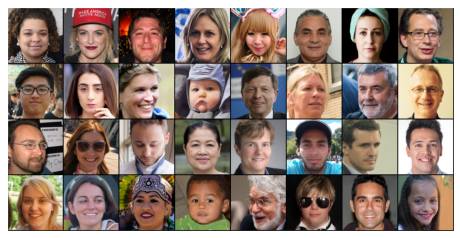

In [19]:
show_batch(train_dl)

In [20]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [21]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [22]:
train_dl = DeviceDataLoader(train_dl, device)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [23]:
hidden_dims = [32,64,128,256,512]
layers = []
input_size = 3
input_temp = input_size
for dim in hidden_dims:
  layers.append(
      nn.Sequential(
          nn.Conv2d(input_temp, out_channels=dim, kernel_size=4, stride=2, padding=1, bias=False),
          nn.BatchNorm2d(dim),
          nn.LeakyReLU(0.2, inplace=True),
          nn.Dropout2d(p=0.05))
  )
  input_temp = dim

layers.append(nn.Conv2d(hidden_dims[-1], 1, kernel_size=4, stride=1, padding=0, bias=False))
layers.append(nn.Flatten())
layers.append(nn.Sigmoid())
discriminator = nn.Sequential(*layers)


In [24]:
discriminator = to_device(discriminator, device)

In [25]:
latent_size = 128

In [26]:
hidden_dims.reverse()
layers = []
input_temp = latent_size

for i,dim in enumerate(hidden_dims):
  pad = 1
  shift = 2
  if i == 0:
    pad = 0
    shift = 1
  layers.append(
      nn.Sequential(
          nn.ConvTranspose2d(input_temp, dim, kernel_size=4, stride=shift, padding=pad, bias=False),
          nn.BatchNorm2d(dim),
          nn.LeakyReLU(0.2, inplace=True),
          nn.Dropout2d(p=0.1))
  )
  input_temp = dim

layers.append(nn.ConvTranspose2d(hidden_dims[-1], input_size, kernel_size=4, stride=2, padding=1, bias=False))
layers.append(nn.Tanh())

generator = nn.Sequential(*layers)

torch.Size([32, 3, 128, 128])


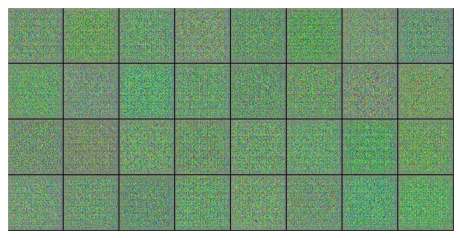

In [27]:
xb = torch.randn(batch_size, latent_size, 1, 1) 
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [28]:
generator = to_device(generator, device)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [29]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [30]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [31]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [32]:
lr = 3e-3
 
model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

epochs = 20

best_generator_path = "./best-generator-parameters.pt"
best_discriminator_path = "./best-discriminator-parameters.pt"


In [33]:
def fit(model, criterion, epochs, lr, start_idx=1):
    min_loss_g = 10
    min_loss_d = 10
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        g_loss_append = np.mean(loss_g_per_epoch)
        d_loss_append = np.mean(loss_d_per_epoch)
        losses_g.append(g_loss_append)
        losses_d.append(d_loss_append)
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))

        #save best model

        if min_loss_g > g_loss_append:
          min_loss_g = g_loss_append
          torch.save(model["generator"].state_dict(), best_generator_path)
        if min_loss_d > d_loss_append:
          min_loss_d = d_loss_append
          torch.save(model["discriminator"].state_dict(), best_discriminator_path)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
        # Save generated images
        if epoch == epochs - 1:
          save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores
  

In [34]:
history = fit(model, criterion, epochs, lr)

  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [1/20], loss_g: 4.2330, loss_d: 1.3747, real_score: 0.7692, fake_score: 0.2610


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [2/20], loss_g: 2.2216, loss_d: 1.6798, real_score: 0.5984, fake_score: 0.4077


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [3/20], loss_g: 2.2044, loss_d: 1.4572, real_score: 0.6067, fake_score: 0.4076


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [4/20], loss_g: 2.2815, loss_d: 1.3183, real_score: 0.6193, fake_score: 0.3779


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [5/20], loss_g: 2.3799, loss_d: 1.2015, real_score: 0.6362, fake_score: 0.3645


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [6/20], loss_g: 2.4468, loss_d: 1.2257, real_score: 0.6397, fake_score: 0.3696


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [7/20], loss_g: 2.2669, loss_d: 1.2363, real_score: 0.6163, fake_score: 0.3789


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [8/20], loss_g: 2.4101, loss_d: 1.1796, real_score: 0.6302, fake_score: 0.3700


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [9/20], loss_g: 2.3526, loss_d: 1.1839, real_score: 0.6381, fake_score: 0.3608


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [10/20], loss_g: 2.3791, loss_d: 1.1229, real_score: 0.6481, fake_score: 0.3539


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [11/20], loss_g: 2.7474, loss_d: 1.0471, real_score: 0.6750, fake_score: 0.3361


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [12/20], loss_g: 2.8845, loss_d: 1.0791, real_score: 0.6716, fake_score: 0.3275


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [13/20], loss_g: 2.9600, loss_d: 1.0542, real_score: 0.6723, fake_score: 0.3212


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [14/20], loss_g: 3.1545, loss_d: 1.0006, real_score: 0.6920, fake_score: 0.3076


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [15/20], loss_g: 3.4776, loss_d: 0.9560, real_score: 0.7172, fake_score: 0.2873


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [16/20], loss_g: 3.5079, loss_d: 0.8858, real_score: 0.7278, fake_score: 0.2646


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [17/20], loss_g: 3.9714, loss_d: 0.7978, real_score: 0.7584, fake_score: 0.2427


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [18/20], loss_g: 4.4729, loss_d: 0.7244, real_score: 0.7852, fake_score: 0.2178


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [19/20], loss_g: 4.4783, loss_d: 0.7373, real_score: 0.7746, fake_score: 0.2151


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [20/20], loss_g: 4.6412, loss_d: 0.7110, real_score: 0.7875, fake_score: 0.2159
Saving generated-images-0020.png


In [35]:
generated_img = cv2.imread(f'./generated/generated-images-00{epochs}.png')
generated_img = generated_img[:, :, [2, 1, 0]]

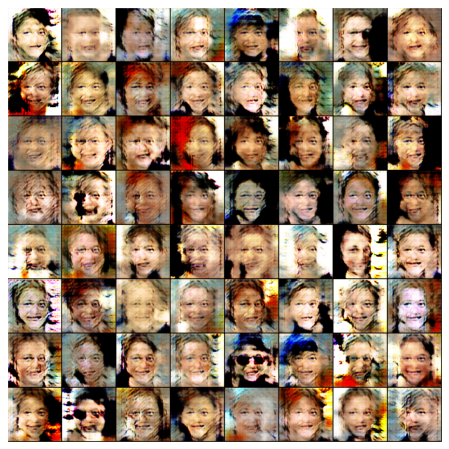

In [36]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img)

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

In [37]:
losses_g, losses_d, real_scores, fake_scores = history

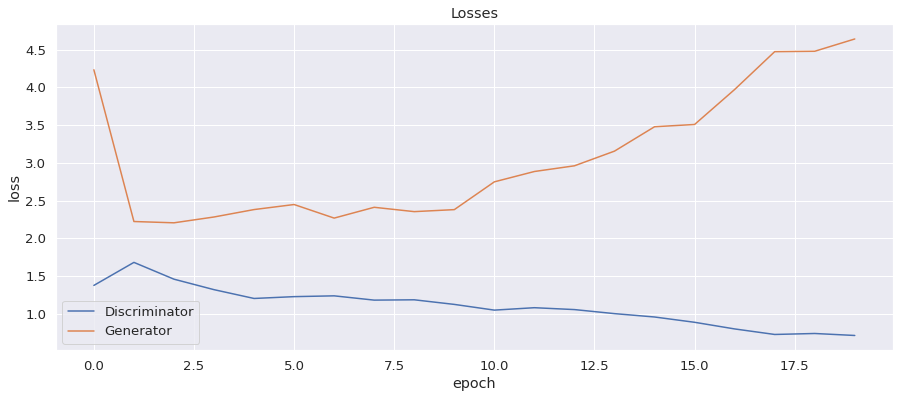

In [38]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

## Часть 3. Генерация изображений (1 балл)

In [39]:
Rise_brothers = True

if Rise_brothers and os.path.exists(best_generator_path):
  generator.load_state_dict(torch.load(best_generator_path))
  discriminator.load_state_dict(torch.load(best_discriminator_path))


Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [40]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent).cpu()

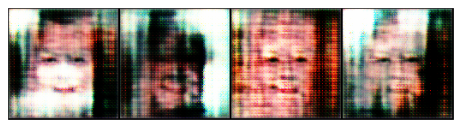

In [41]:
show_images(fake_images, n_images)

Как вам качество получившихся изображений?

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [42]:
train_np = np.array([x.flatten(start_dim=0).numpy() for x,y in train_ds])

In [43]:
train_np.shape

(3143, 49152)

In [44]:
real_target = np.ones((len(train_np)), dtype=int)

In [45]:
fixed_latent = torch.randn(len(train_np), latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

In [46]:
fake_images = fake_images.detach().cpu().flatten(start_dim=1).numpy()

In [47]:
fake_images.shape

(3143, 49152)

In [48]:
fake_target = np.zeros((len(train_np)), dtype=int)

In [49]:
fake_target.shape

(3143,)

In [51]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut



X = np.concatenate((train_np[:500], fake_images[:500]), axis = 0)
y = np.concatenate((real_target[:500], fake_target[:500]), axis = 0)

leave_one_out_scores = []

loo = LeaveOneOut()
loo.get_n_splits(X)

for train_index, test_index in tqdm(loo.split(X)):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  knn = KNeighborsClassifier(n_neighbors = 1)

  knn.fit(X_train, y_train)

  leave_one_out_scores.append(knn.score(X_test,y_test))
  del knn
print(np.mean(leave_one_out_scores))

0it [00:00, ?it/s]

0.986


Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

Accuracy получилась высокая, что значит, мы легко их различаем. Беда!

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

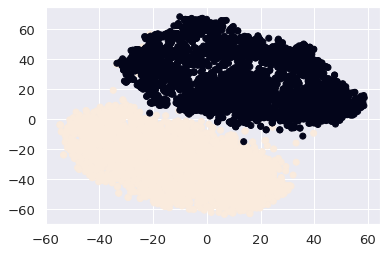

In [52]:
from sklearn.manifold import TSNE

X = np.concatenate((train_np, fake_images), axis = 0)
y = np.concatenate((real_target, fake_target), axis = 0)

X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)

plt.scatter(x = X_embedded[:,0], y = X_embedded[:,1], c = y)
plt.show()

Прокомментируйте получившийся результат:

Но, к сожалению кластеры сильно разлечимы. Обучение прошло плохо, но я старался. Спасибо за внимание